### Bibliotecas

In [70]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import requests
from itertools import zip_longest
import win32com.client as win32
import matplotlib.pyplot as plt
import numpy as np
import locale
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

### Classe do site Kabum

In [71]:
class Kabum_Scraping():
    def __init__(self,navegador):   
        user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        options = webdriver.ChromeOptions()
        options.add_argument(f'user-agent={user_agent}')
        options.add_argument('--disable-notifications')
        options.add_argument('--disable-cookies')
        self.navegador = navegador
        self.navegador.maximize_window()
        self.navegador.get('https://www.kabum.com.br/')


    def iniciar(self):
        self.raspagem_de_dados(produto,termos_banidos)
        self.tratar_dados_coletados()


    def raspagem_de_dados(self,produto,termos_banidos):
        self.navegador.find_element(By.XPATH,'//*[@id="input-busca"]').send_keys(produto,Keys.ENTER)
        time.sleep(3)
        itens = self.navegador.find_elements(By.CLASS_NAME,'productCard')
        self.lista_produtos = []
        for item in itens:
            nome = item.find_element(By.CLASS_NAME,'sc-d99ca57-0').text
            preco = item.find_element(By.CLASS_NAME, 'priceCard').text
            link = item.find_element(By.CLASS_NAME,'sc-ff8a9791-10').get_attribute('href')
            self.lista_produtos.append([nome,preco,link])


    def tratar_dados_coletados(self):
        self.lista_tratada = []
        for item in self.lista_produtos:
            if any(termo in item[0] for termo in termos_banidos.split()) or not all(termo in item[0] for termo in produto.split()):
                continue
            self.lista_tratada.append(item)
        for item in self.lista_tratada:
            preco= item[1].replace(' ','').replace('.','').replace(',','.').replace("R$","")
            item[1] = float(preco)

### Classe do site Mercado Livre

In [72]:
class MercadoLivre_Scraping():
    def __init__(self,navegador):
        self.navegador = navegador
        self.navegador.get('https://www.mercadolivre.com.br/')
    
    
    def iniciar(self):
        self.raspagem_de_dados(produto,termos_banidos)
        self.tratar_dados_coletados()
    
    
    def raspagem_de_dados(self,produto,termos_banidos):
        time.sleep(4)
        self.navegador.find_element(By.XPATH,'//*[@id="cb1-edit"]').send_keys(produto,Keys.ENTER)
        itens = self.navegador.find_elements(By.CLASS_NAME,'ui-search-layout__item')
        self.lista_produtos = []
        for item in itens:
            nome = item.find_element(By.CLASS_NAME,'shops__item-title').text
            preco = item.find_element(By.CLASS_NAME, 'ui-search-price__second-line').text
            link = item.find_element(By.CLASS_NAME,'ui-search-link').get_attribute('href')
            self.lista_produtos.append([nome,preco,link])
    
    
    def tratar_dados_coletados(self):
        self.lista_tratada = []
        for item in self.lista_produtos:
            if any(termo in item[0] for termo in termos_banidos.split()) or not all(termo in item[0] for termo in produto.split()):
                continue
            self.lista_tratada.append(item)
        for item in self.lista_tratada:
            try:
                preco = item[1][:5]    
                item[1] = float(preco)
            except:
                preco = item[1][:4]    
                item[1] = float(preco)

### Classe do site Amazon

In [73]:
class AmazonScraping():
    def __init__(self,navegador):
        self.navegador = navegador
        self.navegador.get('https://www.amazon.com.br/')
        time.sleep(2)
    
    
    def iniciar(self):
        self.raspagem_de_dados(produto,termos_banidos)
        self.tratar_dados_coletados()
    
    
    def raspagem_de_dados(self,produto,termos_banidos):
        self.navegador.find_element(By.XPATH,'//*[@id="twotabsearchtextbox"]').send_keys(produto,Keys.ENTER)
        time.sleep(5)
        self.itens = navegador.find_elements(By.XPATH,'//div[@class="a-section a-spacing-base"]')
        time.sleep(3)
        self.lista_produtos = []
        for item in self.itens:
            nome= item.find_element(By.CLASS_NAME,'a-text-normal').text
            try:
                preco= item.find_element(By.CLASS_NAME,'a-price-whole').text
            except:
                continue
            link = item.find_element(By.CLASS_NAME,'a-link-normal').get_attribute('href')
            self.lista_produtos.append([nome,preco,link])
        
    
    def tratar_dados_coletados(self):
        self.lista_tratada = []
        for item in self.lista_produtos:
            if any(termo in item[0] for termo in termos_banidos.split()) or not all(termo in item[0] for termo in produto.split()):
                continue
            self.lista_tratada.append(item)
        for item in self.lista_tratada:
            item[1] = str(item[1]).replace('.','')
            item[1] = float(item[1])  

### Navegador e variáveis

In [74]:
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
chrome_options = Options()
chrome_options.add_argument('--disable-notifications')
chrome_options.add_argument('--disable-cookies')
chrome_options.add_argument(f'user-agent={user_agent}')
navegador = webdriver.Chrome(options=chrome_options)
navegador.maximize_window()
produto = 'Samsung Galaxy S22 Ultra'
termos_banidos = 'S23 S21 Capa Película carteira'

### Chamando as classes

In [75]:
kabum = Kabum_Scraping(navegador)
kabum.iniciar()
mercado_livre = MercadoLivre_Scraping(navegador)
mercado_livre.iniciar()
amazon = AmazonScraping(navegador)
amazon.iniciar()

### Classe do envio de planilha e pdf por email

In [76]:
class enviar_email_com_pdf_e_excel():
    
    
    def iniciar(self):
        self.criar_df_produtos()
        self.dados_do_grafico()
        self.gerar_grafico()
        self.gerar_pdf()
        self.enviar_email()
    
    
    def criar_df_produtos(self):
        self.df_produtos = pd.DataFrame(columns=['Nome', 'Preço', 'Link'])
        self.df_produtos = pd.concat([self.df_produtos, pd.DataFrame(kabum.lista_tratada, columns=['Nome', 'Preço', 'Link'])])
        self.df_produtos = pd.concat([self.df_produtos, pd.DataFrame(mercado_livre.lista_tratada, columns=['Nome', 'Preço', 'Link'])])
        self.df_produtos = pd.concat([self.df_produtos, pd.DataFrame(amazon.lista_tratada, columns=['Nome', 'Preço', 'Link'])])
        self.df_produtos.to_excel('Produtos.xlsx',index = False)
        
        
    def dados_do_grafico(self):
        self.df_web_sraping = pd.read_excel('Produtos.xlsx')
        self.df_kabum = self.df_web_sraping[self.df_web_sraping['Link'].str.contains('kabum')]
        self.media_kabum = self.df_kabum['Preço'].mean()
        self.maximo_kabum = self.df_kabum['Preço'].max()
        self.minimo_kabum = self.df_kabum['Preço'].min()
        self.df_mercado_livre = self.df_web_sraping[self.df_web_sraping['Link'].str.contains('mercadolivre')]
        self.media_mercado_livre = self.df_mercado_livre ['Preço'].mean()
        self.maximo_mercado_livre = self.df_mercado_livre ['Preço'].max()
        self.minimo_mercado_livre = self.df_mercado_livre ['Preço'].min()
        self.df_amazon = self.df_web_sraping[self.df_web_sraping['Link'].str.contains('amazon')]
        self.media_amazon = self.df_amazon['Preço'].mean()
        self.maximo_amazon = self.df_amazon['Preço'].max()
        self.minimo_amazon = self.df_amazon['Preço'].min()
        self.media = [self.media_kabum, self.media_mercado_livre, self.media_amazon]
        self.maximo = [self.maximo_kabum, self.maximo_mercado_livre, self.maximo_amazon]
        self.minimo = [self.minimo_kabum, self.minimo_mercado_livre, self.minimo_amazon]
        
        
    def gerar_grafico(self):
        plt.figure(figsize=(16, 6))
        locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
        bar_width = 0.28
        index = np.arange(len(self.media))
        plt.bar(index, self.media, bar_width, label='Média',color='#AF4F41')
        plt.bar(index + bar_width, self.maximo, bar_width, label='Máximo', color='#273248')
        plt.bar(index + 2*bar_width, self.minimo, bar_width, label='Mínimo',color='#FC7643')
        for i, v in enumerate(self.media):
            x = i
            y = v + 0.4
            plt.text(x, y, locale.currency(v, grouping=True), fontsize=12, ha='center', va='bottom')
        for i, v in enumerate(self.maximo):
            x = i + bar_width
            y = v + 0.4
            plt.text(x, y, locale.currency(v, grouping=True), fontsize=12, ha='center', va='bottom')
        for i, v in enumerate(self.minimo):
            x = i + 2*bar_width
            y = v + 0.4
            plt.text(x, y, locale.currency(v, grouping=True), fontsize=12, ha='center', va='bottom')
        plt.xticks(index + bar_width, ['Kabum', 'Mercado Livre', 'Amazon'])
        plt.legend()
        plt.savefig('Gráfico.png', dpi=400, bbox_inches='tight')
        plt.show()
    
    
    def gerar_pdf(self):
        cnv = canvas.Canvas('Relatório.pdf', pagesize=A4)
        margin_top = 10/ 0.35277
        margin_bottom = 30/ 0.35277
        margin_left = 20/ 0.35277
        margin_right = 20/ 0.35277
        text_width = A4[0] - margin_left - margin_right
        text_height = A4[1] - margin_top - margin_bottom
        cnv.setFont('Helvetica-Bold', 18)
        titulo = 'RELATÓRIO DE PREÇOS'
        titulo_width = cnv.stringWidth(titulo)
        cnv.drawString(margin_left, A4[1] - margin_top - 30, titulo)
        cnv.setFont('Helvetica', 12)
        texto = 'Com base nos dados apresentados, é possível observar que o preço do celular Samsung S22 Ultra varia significativamente entre as três lojas, com preços máximos que variam de R$ 8299 a R$ 8999 e preços mínimos que variam de R$ 4299 a R$ 5499. A média de preços na Kabum é de R$ 6396,39, enquanto que no Mercado Livre e na Amazon é de R$ 6422. Portanto, pode-se dizer que os preços médios nas três lojas são semelhantes. Mas no geral, baseado nos dados, é mais vantajoso comprar pelo Mercado Livre.'
        lines = []
        words = texto.split(' ')
        current_line = ''
        for word in words:
            if cnv.stringWidth(current_line + ' ' + word) <= text_width:
                current_line += ' ' + word
            else:
                lines.append(current_line.strip())
                current_line = word
        lines.append(current_line.strip())
        y = A4[1] - margin_top - 80
        for line in lines:
            cnv.drawString(margin_left, y, line)
            y -= 18
        img_width, img_height = (480, 200)  
        cnv.drawImage('Gráfico.png', margin_left, y - img_height, width=img_width, height=img_height)
        cnv.save()
        
        
    def enviar_email(self):
        if len(self.df_web_sraping.index) > 0:
            outlook = win32.Dispatch('outlook.application')
            mail = outlook.CreateItem(0)
            mail.To = 'danielcardosomds@gmail.com'
            mail.Subject = 'Produtos Encontrados'
            mail.HTMLBody = f"""
            <p>Prezado,</p>
            <p>Encontramos alguns produtos em oferta dentro critérios desejados. Segue em anexo o relatório em PDF e a planilha em Excel.</p>
            <p>Qualquer dúvida estou à disposição</p>
            <p>Att.,</p>
            """
            attachment_pdf = mail.Attachments.Add(r'C:\Users\T-Gamer\Desktop\python\Projeto 2\Web Scraping\Relatório.pdf')
            attachment_pdf = mail.Attachments.Add(r'C:\Users\T-Gamer\Desktop\python\Projeto 2\Web Scraping\Produtos.xlsx')
            mail.Send()

        navegador.quit()  
            

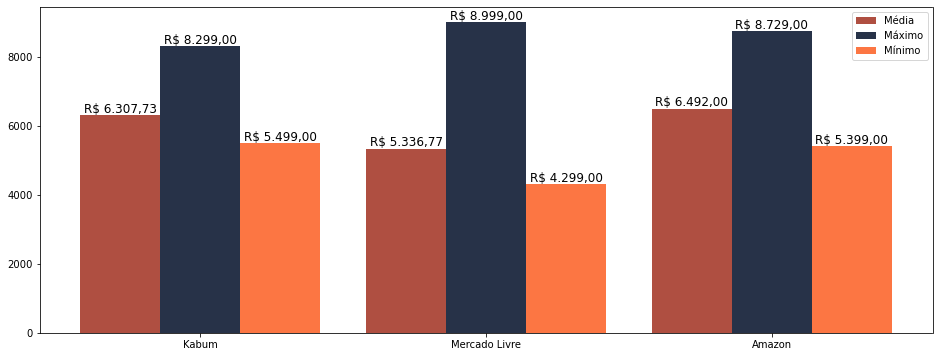

In [77]:
email = enviar_email_com_pdf_e_excel()
email.iniciar()